# Optimizing the model
At this stage of the assignment, finding the optimal model architecture with necessary hyper-parameters is aimed. For easy testing, GPU utilization is performed.
## Necessary Imports
As the necessary imports, the model template implemented and the data utilities are imported. To fasten up the testing process, data compression into a **h5** file is implenented and used.

In [13]:
import tensorflow as tf
from data.data_utils import Dataset, save_dataset
import os
from model import AgeModel
import tensorflow.keras.losses as losses

# Set following config to resolve GPU errors
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
sess.as_default()
print("Tensorflow version used: {}".format(tf.__version__))

Tensorflow version used: 2.3.0


## Hardware utilization
The utilization of the GPU effects the training time significantly for this assignment. To ensure that this implementation uses GPU, as an initial stage the presence of the GPU is checked. Even though it is not stated in the assignment that this utilization is not compulsory, it is performed for faster model evaluation.

In [14]:
from tensorflow.python.client import device_lib
def check_if_gpu_used():
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    if len(gpu_names) >= 1:
        print("Number of GPUs used by Tensorflow: {}".format(len(gpu_names)))
    else:
        print("Tensorflow operates on CPU now.")
check_if_gpu_used()

Number of GPUs used by Tensorflow: 1


## Importing the dataset
The dataset given for the assignment is modeled with **Dataset** class. The importing process is as follows.

In [15]:
import h5py
import numpy as np
datafile_path = os.path.join(data_path, "dataset.h5")
#save_dataset(data_path, dataset) # Compressing data in h5 format
start = time()
f = h5py.File(datafile_path, "r")
train_samples = np.array(f["train_samples"])
train_labels = np.array(f["train_labels"])
val_samples = np.array(f["val_samples"])
val_labels = np.array(f["val_labels"])
test_samples = np.array(f["test_samples"])
test_labels = np.array(f["test_labels"])
end = time()
f.close()
print("Monitoring compressed data details")
## Training set
print("Training data shape: {}".format(train_samples.shape))
print("Training labels shape: {}".format(train_labels.shape))
## Validation set
print("Validation data shape: {}".format(val_samples.shape))
print("Validation labels shape: {}".format(val_labels.shape))
## Test set
print("Testing data shape: {}".format(test_samples.shape))
print("Testing labels shape: {}".format(test_labels.shape))
print("Time to construct the dataset from compressed file: {:.3f} seconds".format(end - start))

Monitoring compressed data details
Training data shape: (5400, 91, 91, 1)
Training labels shape: (5400,)
Validation data shape: (2315, 91, 91, 1)
Validation labels shape: (2315,)
Testing data shape: (1159, 91, 91, 1)
Testing labels shape: (1159,)
Time to construct the dataset from compressed file: 3.294 seconds


## Initial non-regularized model and checking the power of it
For our initial model, we benefited from the architecture proposed for VGG-16 and formed a similar model to it. To see whether it is powerful enough, we trained it on a small amount of data. In this task, we specified the amount of data as 20 samples.

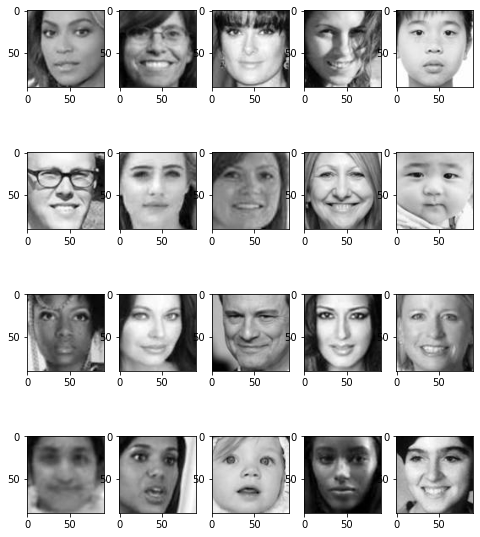

In [16]:
# Generate random data indexes
random_idx = np.random.permutation(train_samples.shape[0])
random_train_samples = train_samples[random_idx[:20]]
random_train_labels = train_labels[random_idx[:20]]
fig, axes = plt.subplots(4,5, figsize=(8,10))
for img_idx in range(random_train_samples.shape[0]):
    row = img_idx // 5
    col = img_idx % 5
    axes[row, col].imshow(random_train_samples[img_idx], cmap="gray")

In [17]:
# Model specification
non_regularized_model = []
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None,"reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "conv2d", "filters": 256, "kernel_size": (1,1), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "flatten"})
non_regularized_model.append({"type": "dense", "units": 256, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 128, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 64, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})
non_regularized_model.append({"type": "dense", "units": 1, "activation": "relu", "initializer": "xavier", "regularizer": None, "reg_ratio": None})

In [18]:
# Building the model
model_to_overfit = AgeModel(non_regularized_model, "channels_last")
model_to_overfit.build_comp_graph((None, 91, 91, 1)) # Building computational graph to monitor dimensions of layer matrices
model_to_overfit.summary()

Model: "age_model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1040 (Conv2D)         (None, 89, 89, 32)        320       
_________________________________________________________________
conv2d_1041 (Conv2D)         (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_312 (MaxPoolin (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_1042 (Conv2D)         (None, 41, 41, 64)        18496     
_________________________________________________________________
conv2d_1043 (Conv2D)         (None, 39, 39, 64)        36928     
_________________________________________________________________
max_pooling2d_313 (MaxPoolin (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_1044 (Conv2D)         (None, 17, 17, 128)     

Loss for the non-regularized model after 2000 epochs: 0.17619365453720093
Minimum loss value achieved: 0.07753153890371323


Text(0.5, 1.0, 'Loss plot for the non-regularized model')

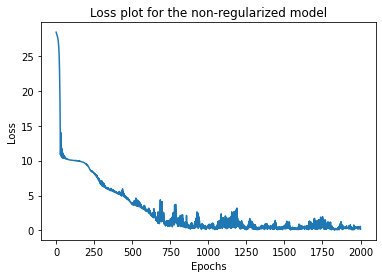

In [19]:
# Compile and run the model
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanAbsoluteError()
model_to_overfit.compile(loss=loss, optimizer=optim)
history = model_to_overfit.fit(x=random_train_samples, y=random_train_labels, epochs=2000, verbose=0)
losses = history.history["loss"]
print("Loss for the non-regularized model after 2000 epochs: {}".format(losses[-1]))
print("Minimum loss value achieved: {}".format(np.amin(losses)))
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot for the non-regularized model")

## Searching for optimal learning rate and regularization
Given the model for testing whteher the model complexity is enough, a coarse search is performed to find the optimal regularization and learning rate values. The initial model architecture is selected considering the previous stage. The function **get_model_with_ratio** is given for constructing model metadata with a given regularization parameter. Here the initial choice for a regularization is selected as L2. In this step the learning rate and regularization parameter is optimized on the training set (w.r.t. validation loss) by performing simple trainings (5 epochs).

In [20]:
def get_model_with_reg(reg_ratio):
    reg_model = []
    reg_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
    reg_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
    reg_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
    reg_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "conv2d", "filters": 256, "kernel_size": (1,1), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "flatten"})
    reg_model.append({"type": "dense", "units": 256, "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "dense", "units": 128, "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "dense", "units": 64, "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    reg_model.append({"type": "dense", "units": 1, "activation": "relu", "initializer": "xavier", "regularizer": "l2", "reg_ratio": reg_ratio})
    return reg_model

In [21]:
!pip install tqdm
from tqdm import tqdm
def optimize_lr_reg(step_count, training_samples, training_labels, valid_samples, valid_labels):
    lr_exp = np.random.uniform(-6, -3, step_count)
    reg_exp = np.random.uniform(-4, -1, step_count)
    results = []
    # Results stored as (val_loss, train_loss, lr, reg_ratio)
    for exp_idx in tqdm(range(step_count)):
        model_metadata = get_model_with_reg(10**reg_exp[exp_idx])
        exp_model = AgeModel(model_metadata, "channels_last")
        exp_model.build_comp_graph((None, 91, 91, 1))
        optim = tf.keras.optimizers.Adam(learning_rate=10**lr_exp[exp_idx])
        loss = tf.keras.losses.MeanAbsoluteError()
        model_to_overfit.compile(loss=loss, optimizer=optim)
        history = model_to_overfit.fit(x=training_samples, y=training_labels, epochs=5, verbose=0, validation_data=(valid_samples, valid_labels))
        results.append((history.history["val_loss"][-1], history.history["loss"][-1], lr_exp[exp_idx], reg_exp[exp_idx]))
    results.sort(key=lambda x: x[0])
    return results
exp_results = optimize_lr_reg(100, train_samples[random_idx[:500]], train_labels[random_idx[:500]], val_samples, val_labels)
# Best 10 results - by validation loss
print(exp_results[:10])

100%|██████████| 100/100 [18:49<00:00, 11.29s/it][(10.617694854736328, 2.064957618713379, -3.4844628912433766, -1.3941280584284281), (10.659607887268066, 6.384646892547607, -5.319003507258784, -2.7257543199818883), (10.679749488830566, 1.1899827718734741, -4.139370203789122, -2.0738647149267697), (10.808293342590332, 1.2893657684326172, -4.564216195430041, -2.187383540895718), (10.820465087890625, 2.8476924896240234, -5.2233948174216716, -1.7236038962712619), (10.82492446899414, 2.69124436378479, -5.039565688455186, -1.3814948823908475), (10.841259002685547, 1.6265671253204346, -4.7865506316725925, -1.7970470062877673), (10.843069076538086, 1.5562098026275635, -5.186295728401723, -3.5151152122261005), (10.849942207336426, 1.4193936586380005, -5.254319863443715, -2.709233504625175), (10.858551979064941, 1.7630867958068848, -5.160497513781063, -3.561210773146144)]



After performign the initial experiment, the optimal learning rate is guessed to be around $10^{-4}$ and $10^{-5}$ where the optimal regularization would be in between $10^{-1}$ and $10^{-2}$. In order to get more detail about this issue, a second stage is performed with smaller ranges

In [22]:
def lr_reg_small_range(step_count, training_samples, training_labels, valid_samples, valid_labels):
    lr_exp = np.random.uniform(-5, -3, step_count)
    reg_exp = np.random.uniform(-2, 0, step_count)
    results = []
    # Results stored as (val_loss, train_loss, lr, reg_ratio)
    for exp_idx in tqdm(range(step_count)):
        model_metadata = get_model_with_reg(10**reg_exp[exp_idx])
        exp_model = AgeModel(model_metadata, "channels_last")
        exp_model.build_comp_graph((None, 91, 91, 1))
        optim = tf.keras.optimizers.Adam(learning_rate=10**lr_exp[exp_idx])
        loss = tf.keras.losses.MeanAbsoluteError()
        model_to_overfit.compile(loss=loss, optimizer=optim)
        history = model_to_overfit.fit(x=training_samples, y=training_labels, epochs=5, verbose=0, validation_data=(valid_samples, valid_labels))
        results.append((history.history["val_loss"][-1], history.history["loss"][-1], lr_exp[exp_idx], reg_exp[exp_idx]))
    results.sort(key=lambda x: x[0])
    return results
exp_results_2 = optimize_lr_reg(30, train_samples[random_idx[:500]], train_labels[random_idx[:500]], val_samples, val_labels)
# Best 10 results - by validation loss
print(exp_results_2[:10])

100%|██████████| 30/30 [05:36<00:00, 11.23s/it][(10.443587303161621, 0.5461378693580627, -4.028239578252033, -3.867076009605284), (10.471416473388672, 0.5859177708625793, -4.9435279742587515, -3.8533810553287617), (10.477374076843262, 0.4540000259876251, -4.674679590062267, -3.277664794469426), (10.479042053222656, 0.24928101897239685, -5.0848417437397995, -1.3597272465730552), (10.480152130126953, 0.31651413440704346, -4.735388863789003, -1.2415018569937546), (10.48018741607666, 0.8337154388427734, -4.67691006867762, -2.872766135468497), (10.481213569641113, 0.7748059034347534, -4.0880259768738405, -3.811822676542348), (10.493735313415527, 0.44085079431533813, -5.299355895738208, -2.0279691669259146), (10.496761322021484, 0.19934967160224915, -5.49424841029026, -1.4077672451329475), (10.507352828979492, 0.3369830548763275, -4.420394654137214, -3.3266927025859334)]

